In [9]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
from datetime import datetime
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
# import getSamples as gs

In [7]:
# downloaded from https://github.com/dswah/sgcrfpy
from sgcrf import SparseGaussianCRF

In [8]:
df = pd.read_csv('fservice.csv')
c = ['Anonymous','AssignTo', 'RequestType', 'RequestSource','CD','Direction', 'ActionTaken', 'APC' ,'AddressVerified']
d = ['Latitude', 'Longitude']

/Users/andyhan/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (20,33) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Feature cleaning (for CD == 5)

In [24]:
df = df[df['CD'] == 5.0]

In [149]:
dfn = df.filter(items = c + d + ['ElapsedDays'] + ['Seven'])
dfn = dfn.dropna()
    
XCAT = dfn.filter(items = c).values
XNUM = dfn.filter(items = d).values
    
y_reg = dfn['ElapsedDays'] 
y_clas = dfn['ElapsedDays'] <= 7
    
labelencoder_X = LabelEncoder()
for num in range(len(c)): 
    XCAT[:, num] = labelencoder_X.fit_transform(XCAT[:, num])
            
onehotencoder = OneHotEncoder()
XCAT = onehotencoder.fit_transform(XCAT).toarray()
    
X = np.concatenate((XCAT, XNUM), axis=1)

XN = X[:10]
yn = y[:10]

X = X[10:]
y_reg = y_reg[10:]
y_clas = y_clas[10:]

In [150]:
# Change y-values to numbery
y_clas = pd.get_dummies(y_clas)
y_clas = y_clas.drop(columns=False)

In [151]:
X_train, X_test, y_reg_train, y_reg_test = train_test_split(X, y_reg, test_size = 0.2, random_state = 0)
X_train, X_val, y_reg_train, y_reg_val = train_test_split(X_train, y_reg_train, test_size = 0.2, random_state = 0)

In [152]:
X_train, X_test, y_clas_train, y_clas_test = train_test_split(X, y_clas, test_size = 0.2, random_state = 0)
X_train, X_val, y_clas_train, y_clas_val = train_test_split(X_train, y_clas_train, test_size = 0.2, random_state = 0)

In [153]:
X_train = np.asarray(X_train)
X_val = np.asarray(X_val)

y_reg_train = np.asarray(y_reg_train)
y_reg_val = np.asarray(y_reg_val)

y_clas_train = np.asarray(y_clas_train)
y_clas_val = np.asarray(y_clas_val)

In [137]:
# change to 2-d arrays cause i think the model needs 2d
y_reg_train = y_reg_train.reshape((-1, 1))
y_reg_val = y_reg_val.reshape(-1, 1)

## RMSE

In [138]:
def rmse(y_hat,y):
    #Method 1
    #Get RMSE over each day
    rmse_days = np.sqrt(mean_squared_error(y_hat, y, multioutput='raw_values'))
    #Get average RMSE
    rmse1 = sum(rmse_days)/len(rmse_days)
    rmse1 = round(rmse1,2)
    #Method 2
    #Get sum of squares per day
    sum_of_squares = sum((y_hat - y)**2)
    #sum over days, divide by (num_days * num_samples), take sqrt()
    rmse2 = np.sqrt(sum(sum_of_squares)/(y_hat.shape[1]*y_hat.shape[0]))
    rmse2 = round(rmse2,2)

    rmse_days = rmse_days.tolist()
    rmse_days = [round(x,2) for x in rmse_days]

    return rmse_days,rmse1,rmse2

# SGCRF

looks like SGCRF is a regression model? so what we can do is either:
1. embrace the regression and predict how many days a request will take, or 
2. coerce the (regression) predictions into classification by rounding

### option 1

In [139]:
model1 = SparseGaussianCRF(lamL=0.1, lamT=0.1, n_iter=10000)
predictions1 = []

# take the average of ITERATIONS predictions — the NY team does this
ITERATIONS = 3

for i in range(0, ITERATIONS):
    model.fit(X_train, y_reg_train)
    prediction1 = model.predict(X_val)
    predictions1.append(prediction1)

predictions1 = np.array(predictions1)
predictions1 = np.mean(predictions1, axis=0)  # average

100% |########################################################################|
100% |########################################################################|
100% |########################################################################|


### option 2

In [157]:
model2 = SparseGaussianCRF(lamL=0.1, lamT=0.1, n_iter=10000)
predictions2 = []

# take the average of ITERATIONS predictions — the NY team does this
ITERATIONS = 3

for i in range(0, ITERATIONS):
    model.fit(X_train, y_clas_train)
    prediction2 = model.predict(X_val)
    predictions2.append(prediction2)

predictions2 = np.array(predictions2)
predictions2 = np.mean(predictions2, axis=0)  # average

100% |########################################################################|
100% |########################################################################|
100% |########################################################################|


In [160]:
for i, prediction in enumerate(predictions2):
    if prediction < 0.5:
        predictions2[i] = 0
    else:
        predictions2[i] = 1

In [161]:
predictions2[:10]

array([[1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.]])

## testing

In [156]:
# option 1. the units are days
print(rmse(predictions1, y_reg_val))

([14.57], 14.57, 2564.32)


In [ ]:
# holy shit that's terrible

In [162]:
# option 2
print("Accuracy:", metrics.accuracy_score(y_clas_val, predictions2))

Accuracy: 0.8477429545265608


In [ ]:
# holy shit that's terrible too

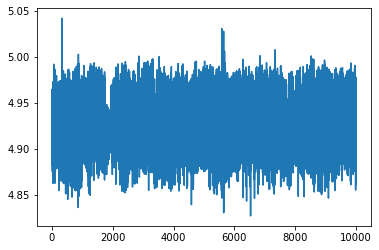

In [163]:
loss = model.lnll
plt.plot(loss)
# lol no idea what this fugly graph means